# Device hamiltonian
Ricordiamo l'hamiltoniana di un quantum annealer

$$ \mathcal{H}_{\text{ising}} = - \frac{A(s)}{2} \left( \sum_i \hat{\sigma}_x^{(i)} \right) + \frac{B(s)}{2} \left( \sum_i h_i \hat{\sigma}_z^{(i)} + \sum_{i>j} J_{i,j} \hat{\sigma}_z^{(i)} \hat{\sigma}_z^{(j)} \right) $$

dove $A(s), B(s)$ dipendono dal device, mentre $h_i, J_{i,j}$ sono definiti dall'utente.

In [10]:
%matplotlib inline

import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt

df = pd.read_excel('09-1216A-A_DW_2000Q_6_annealing_schedule.xls', sheet_name=1)

In [2]:
df.head()

,s,A(s) (GHz),B(s) (GHz),C (normalized)
0,0.000000,9.965879,0.062970,0.000000
1,0.001001,9.909568,0.064592,0.003373
2,0.002002,9.854917,0.066236,0.006623
3,0.003003,9.800594,0.067900,0.009849
4,0.004004,9.746270,0.069585,0.013074


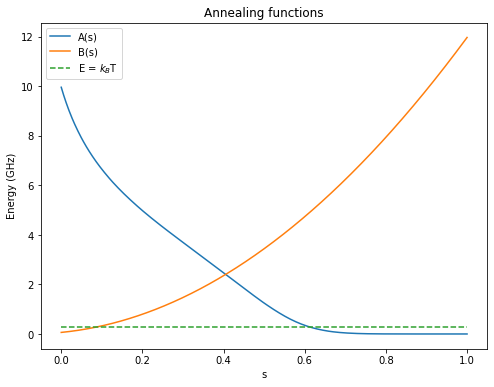

In [3]:
plt.figure(figsize=(8, 6))
plt.plot(df['s'], df['A(s) (GHz)'], label='A(s)')
plt.plot(df['s'], df['B(s) (GHz)'], label='B(s)')
plt.plot(np.linspace(0,1), 0.29 * np.ones(50), linestyle='--', label='E = $k_B$T')

plt.title('Annealing functions')
plt.xlabel('s')
plt.ylabel('Energy (GHz)')
plt.legend()
plt.show()

# Single qubit temperature measurements
Riducendosi a considerare un singolo spin, abbiamo libertà di scegliere *h* e il parametro di annealing *s(t)*.
$$ \quad \forall i,j \quad J_{i,j}=0 $$

$$ \mathcal{H}_{\text{single qubit}} = - \frac{A(s)}{2} \hat{\sigma}_x + \frac{B(s)}{2} h \hat{\sigma}_z $$

Salto minimo di energia: 1.9038426749250454e-07 GHz


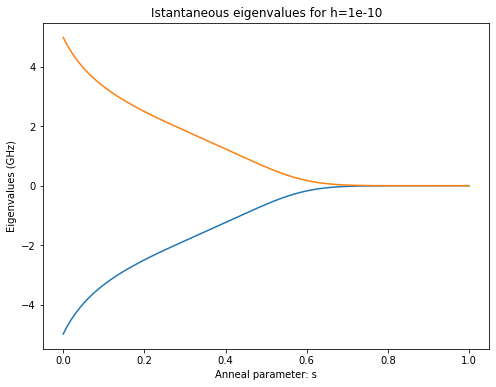

In [4]:
# plot hamiltonian istantanous eigenvalues
h = 1e-10

sigma_x = np.array([[0, 1], [1, 0]])
sigma_z = np.diag([1, -1])
A_s = df['A(s) (GHz)'].to_numpy()
B_s = df['B(s) (GHz)'].to_numpy()

# H è una lista di matrici, eigenvals è una lista di coppie di autovalori
H = [a / 2 * sigma_x + b / 2 * h * sigma_z for a, b in zip(A_s, B_s)]
eigenvals = [np.linalg.eigvalsh(hamilt) for hamilt in H]

anneal_parameter = np.linspace(0, 1, len(eigenvals))
negative_eigenvals, positive_eigenvals = np.array(eigenvals).T
print(f'Salto minimo di energia: {np.min(positive_eigenvals - negative_eigenvals)} GHz')

# faccio la figura
plt.figure(figsize=(8,6))
plt.plot(anneal_parameter, negative_eigenvals)
plt.plot(anneal_parameter, positive_eigenvals)

plt.title(f'Istantaneous eigenvalues for h={h}')
plt.xlabel('Anneal parameter: s')
plt.ylabel('Eigenvalues (GHz)')
plt.show()

In [5]:
# cerco quali device sono disponibili al momento
from dwave.cloud import Client

with Client.from_config() as client:
    for solver in client.get_solvers():
        print(solver.id)

hybrid_binary_quadratic_model_version2
hybrid_discrete_quadratic_model_version1
Advantage_system1.1
DW_2000Q_6


In [6]:
# scelgo il device e mi assicuro di poterci comunicare
from dwave.system import DWaveSampler

sampler = DWaveSampler(solver='DW_2000Q_6')

print(f'Maximum anneal-schedule points: {sampler.properties["max_anneal_schedule_points"]}')
print(f'Annealing time range: {sampler.properties["annealing_time_range"]} \u03BCs')
print(f'Maximum slope allowed on this solver is {1.0/sampler.properties["annealing_time_range"][0]}')

Maximum anneal-schedule points: 12
Annealing time range: [1, 2000] μs
Maximum slope allowed on this solver is 1.0


## Boltzmann distribution

Naively, one might expect the final distribution at the end of the anneal to be a classical Boltzmann distribution
for the problem Hamiltonian H at the operating temperature of the device, specifically,

$$\rho \sim \exp (- \beta B(1) h \hat{\sigma}_z / 2), \qquad \text{where} \quad \beta = 1/k_B T,$$

with T the operating temperature of the annealer (on the order of $10-20mK$). But it has long been known that is not the case.

La dinamica degli stati si ferma quando il tempo scala di evoluzione, governato da A(s) diventa maggiore di $t_f$. L'uguaglianza dei tempi è detta **freezout point**.

La distribuzione finale degli stati sarà simile a $$\rho \sim \exp (- \beta B(s^*) h \hat{\sigma}_z / 2), $$ dove $s^*$ è il freezout point del sistema.

La distribuzione di popolazione che mi aspetto è

$$P_↑/(1-P_↑)=\exp(-\delta E / k_B T) \qquad \text{con} \quad \delta E = h \times B(s^*)/2 $$

### Find T assuming s*= 0.719

In [127]:
linear_offsets = {active_node: h * random.choice([-1, 1]) for active_node in sampler.nodelist}
# sampleset = sampler.sample_ising(linear_offsets, {}, num_reads=10, label=f'Anneal test h={h}')

print(sampleset)

   0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 ... 2047 energy num_oc.
0 +1 -1 -1 -1 +1 -1 +1 -1 -1 -1 -1 -1 +1 +1 -1 -1 -1 -1 ...   +1   -0.0      10
['SPIN', 1 rows, 10 samples, 2041 variables]


In [128]:
# calcoliamo la percentuale di popolamento del ground state
E_min = h * len(linear_offsets)

n_ecc = 0
tot_occ = 0
for record in sampleset.record:
    n_ecc += (record.energy + E_min) / 2 / h * record.num_occurrences
    tot_occ += record.num_occurrences

num_spin_measures = tot_occ * len(linear_offsets)
print(f'Popolamento primo eccitato: {n_ecc} / {num_spin_measures} ({n_ecc/num_spin_measures})')

Popolamento primo eccitato: -1.6543612251060553e-10 / 20410 (-8.105640495375087e-15)


In [11]:
s_star = 0.719

### Find s*

## Initial quench and pause

L'idea è che facendo un veloce quench del qubit, questo vada più spesso nello stato ad alta energia perché guidato dall'*energia cinetica* dell'annealing, rispetto alla distribuzione che avrei andando lentamente (influenzata solo dal bagno termico).

Aspettando sufficiente tempo, lo stato evolve verso una situazione di equilibrio e campionando questa evoluzione riesco a descrivere il processo di termalizzazione.

In [102]:
# parametri
t_quench = 2.0
t_f = 20.0
h0 = 0.0001
# per h = 0.025, l'energia lungo z dovrebbe essere pari all'energia termica

quench_schedule = [[0.0, 0.0], [t_quench, 1.0], [t_f, 1.0]]
linear_offsets = {active_node: h0 if active_node % 2 == 0 else -h0 for active_node in sampler.nodelist}

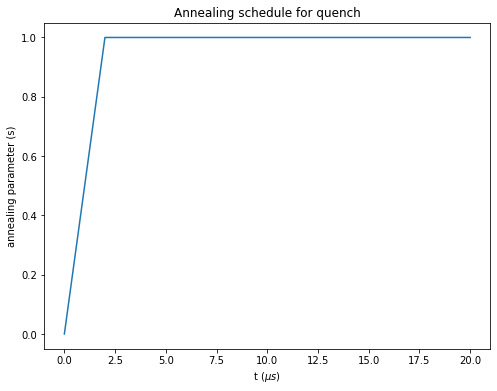

In [110]:
# mostriamo l'annealing schedule
plt.figure(figsize=(8, 6))
plt.plot(*np.array(quench_schedule).T)

plt.title('Annealing schedule for quench')
plt.xlabel('t ($\mu s$)')
plt.ylabel('annealing parameter (s)')
plt.show()

Tuttavia dopo il quench, la dinamica del qubit, governata da $A(s)$, evolve con tempi scala $t>>t_f=200\mu s$

Di conseguenza mi aspetto di non riuscire a vedere la termalizzazione

In [82]:
# campioniamo il sistema dopo il quench
sampler.validate_anneal_schedule(quench_schedule)
sampleset0 = sampler.sample_ising(linear_offsets, {}, num_reads=10, anneal_schedule=quench_schedule, label=f'Quench test h={h}')

print(sampleset0)

   0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 ... 2047 energy num_oc.
0 -1 +1 -1 +1 -1 +1 -1 +1 -1 +1 -1 +1 -1 +1 -1 +1 -1 +1 ...   +1 -2.041      10
['SPIN', 1 rows, 10 samples, 2041 variables]


In [192]:
def print_risultati(sampleset, linear_offsets, h):
    # quanti risultati diversi abbiamo trovato
    print(f'Ho ottenuto {len(sampleset.record)} risultato(i) diverso(i).')
    
    # per ognuno di questi risultati ci facciamo dire se è il minimo globale o no
    for ii in range(len(sampleset.record)):
        results = sampleset.record[ii].sample
        biases = np.array(list(linear_offsets.values()))
        if np.all(np.sign(results) != np.sign(biases)):
            print(f"Tutti gli spin sono nel minimo dell'energia, per h={h}.")
        elif np.all(np.sign(results) == np.sign(biases)):
            print(f"Tutti gli spin sono nel massimo dell'energia, per h={h}.")
        else:
            print("Ho almeno uno spin NON nel minimo/massimo.")

In [7]:
# print_risultati(sampleset0, linear_offsets, h0)

## Classical approach: trivial reverse annealing

In maniera analoga, posso inizializzare il mio stato direttamente in un autostato di $\hat \sigma_z$ utilizzando il reverse annealing, e non modificare il parametro di annealing. Anche in questo caso mi aspetto che la dinamica di evoluzione (classica) si troppo lenta rispetto a $t_f$ e di non riuscire a vedere la termalizzazione.

In [143]:
# parametri
t_f = 20.0
h1 = 0.1
# per h = 0.025, l'energia lungo z dovrebbe essere pari all'energia termica

trivial_reverse_schedule = [[0.0, 1.0], [t_f, 1.0]]
linear_offsets = {active_node: h1 for active_node in sampler.nodelist}
initial_state = {active_node: np.sign(linear_offsets[active_node]) for active_node in linear_offsets}

In [145]:
# campioniamo lo stato finale dell'evoluzione 'termica' di uno stato inizializzato lungo sigma_z
sampler.validate_anneal_schedule(trivial_reverse_schedule)
sampleset = sampler.sample_ising(linear_offsets, {}, num_reads=10, anneal_schedule=trivial_reverse_schedule, initial_state=initial_state, label=f'Trivial reverse annealing test h={h}')

print(sampleset)

   0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 ... 2047 energy num_oc.
0 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 ...   +1  204.1       1
1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 ...   +1  204.1       1
2 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 ...   +1  204.1       1
3 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 ...   +1  204.1       1
4 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 ...   +1  204.1       1
5 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 ...   +1  204.1       1
6 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 ...   +1  204.1       1
7 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 ...   +1  204.1       1
8 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 ...   +1  204.1       1
9 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 +1 ...   +1  204.1       1
['SPIN', 10 rows, 10 samples, 2041 variables]


In [9]:
unique_results = [len(np.unique(sampleset.record[i].sample)) for i in range(len(sampleset))]
print(f'Nelle mie {len(sampleset)} run, ho ottenuto {unique_results} valori unici\n')

# print_risultati(sampleset, linear_offsets, h1)
# sampleset.to_pandas_dataframe()

# Entanglement creation